In [2]:
# import os
# import librosa
# import librosa.display
# import numpy as np
# import matplotlib.pyplot as plt

# def process_audio_files_in_batches(audio_dir, save_dir, img_size=(128, 128), batch_size=10, max_files_per_class=500):
#     """
#     Process .wav files in batches, convert them to mel spectrogram images, and save them in class-specific folders.
#     """
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)
    
#     file_count = {}
#     batch = []
    
#     for root, dirs, files in os.walk(audio_dir):
#         class_name = os.path.basename(root)
#         if class_name not in file_count:
#             file_count[class_name] = 0
        
#         for file in files:
#             if file.endswith('.wav') and file_count[class_name] < max_files_per_class:
#                 file_path = os.path.join(root, file)
#                 batch.append(file_path)
#                 file_count[class_name] += 1

#                 if len(batch) == batch_size:
#                     process_batch(batch, root, save_dir, img_size)
#                     batch = []  # Clear batch after processing

#         # If batch size is not reached but class limit is reached, process the batch
#         if batch and file_count[class_name] >= max_files_per_class:
#             process_batch(batch, root, save_dir, img_size)
#             batch = []

#     # Process any remaining files
#     if batch:
#         process_batch(batch, root, save_dir, img_size)

# def process_batch(batch, root, save_dir, img_size):
#     """
#     Convert a batch of audio files to mel spectrogram images and save them.
#     """
#     for file_path in batch:
#         class_name = os.path.basename(root)
#         class_save_dir = os.path.join(save_dir, class_name)

#         if not os.path.exists(class_save_dir):
#             os.makedirs(class_save_dir)

#         # Load audio file and handle short audio files
#         y, sr = librosa.load(file_path, sr=None)
#         n_fft = min(2048, len(y))  # Adjust n_fft based on the length of the audio signal

#         # Dynamically adjust fmax to be lower than half of the sampling rate (Nyquist frequency)
#         fmax = min(8000, sr / 2)

#         mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=img_size[0], fmax=fmax, n_fft=n_fft)
#         mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

#         # Plot and save the mel spectrogram
#         plt.figure(figsize=(img_size[0]/100, img_size[1]/100))
#         librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
#         plt.axis('off')

#         save_path = os.path.join(class_save_dir, os.path.basename(file_path).replace('.wav', '.png'))
#         plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
#         plt.close()

# # Parameters
# audio_dir = '/mnt/c/Users/baldo/OneDrive - MSFT/Desktop/SIH 24/Audio Dataset/off'
# save_dir = '/mnt/c/Users/baldo/OneDrive - MSFT/Desktop/SIH 24/Mel Spectrogram Dataset/off'
# batch_size = 20
# process_audio_files_in_batches(audio_dir, save_dir, img_size=(128, 128), batch_size=batch_size, max_files_per_class=500)

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import librosa
import librosa.display
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
import itertools

# Function to load dataset and print class distribution
def load_and_preprocess_data(data_dir, batch_size, img_size=(128, 128)):
    train_dataset = image_dataset_from_directory(
        data_dir,
        batch_size=batch_size,
        image_size=img_size,
        label_mode='int',
        seed=123,
        validation_split=0.2,
        subset="training",
        shuffle=True
    )
    
    test_dataset = image_dataset_from_directory(
        data_dir,
        batch_size=batch_size,
        image_size=img_size,
        label_mode='int',
        seed=123,
        validation_split=0.2,
        subset="validation",
        shuffle=True
    )
    
    # Print class distribution
    class_names = train_dataset.class_names
    print(f"Number of Classes: {len(class_names)}")
    class_counts = np.zeros(len(class_names))

    for _, labels in train_dataset:
        class_counts += np.bincount(labels.numpy(), minlength=len(class_names))

    print(f"Samples per Class: {dict(zip(class_names, class_counts))}")
    print(f"Total Samples: {int(np.sum(class_counts))}")

    return train_dataset, test_dataset, class_names


# Load dataset
data_dir = "/mnt/c/Users/baldo/OneDrive - MSFT/Desktop/SIH 24/Mel Spectrogram Dataset"
batch_size = 32
img_size = (128, 128)

train_dataset, val_dataset, class_names = load_and_preprocess_data(data_dir, batch_size, img_size)

2024-09-16 15:13:50.178578: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-16 15:13:50.335160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-16 15:13:50.401148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-16 15:13:50.423499: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-16 15:13:50.547880: I tensorflow/core/platform/cpu_feature_guar

Found 10500 files belonging to 21 classes.
Using 8400 files for training.


I0000 00:00:1726479844.221904   20042 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726479844.367483   20042 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726479844.367545   20042 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726479844.371258   20042 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1726479844.371322   20042 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Found 10500 files belonging to 21 classes.
Using 2100 files for validation.
Number of Classes: 21
Samples per Class: {'backward': 398.0, 'bed': 411.0, 'bird': 404.0, 'cat': 388.0, 'dog': 393.0, 'down': 403.0, 'eight': 393.0, 'five': 407.0, 'follow': 384.0, 'forward': 406.0, 'four': 397.0, 'go': 413.0, 'happy': 405.0, 'house': 403.0, 'learn': 392.0, 'left': 392.0, 'marvin': 405.0, 'nine': 402.0, 'no': 391.0, 'off': 405.0, 'on': 408.0}
Total Samples: 8400


2024-09-16 15:14:16.595230: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


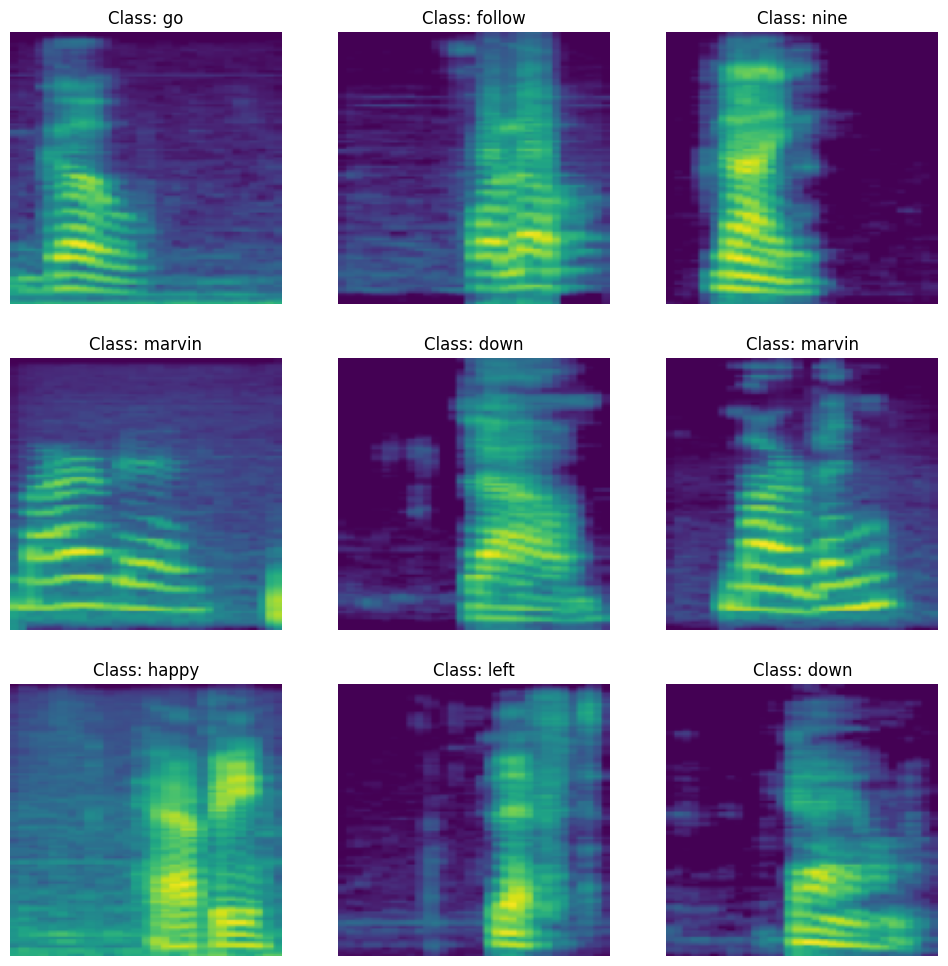

2024-09-16 15:14:16.993763: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [2]:
# Function to visualize the first batch of images
def visualize_first_batch(dataset, class_names):
    for images, labels in dataset.take(1):
        plt.figure(figsize=(12, 12))
        for i in range(min(9, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Class: {class_names[labels[i]]}")
            plt.axis("off")
        plt.show()

# Visualize the first batch
visualize_first_batch(train_dataset, class_names)

In [3]:
# Create CNN backbone for Siamese network
def create_siamese_cnn(input_shape):
    model = Sequential([
        layers.Rescaling(1./255),
        layers.Reshape(input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.BatchNormalization(),
        
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.BatchNormalization(),
        
        layers.Conv2D(256, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.BatchNormalization(),
        
        layers.Conv2D(512, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(64, activation='relu')
    ])
    # model.summary()
    return model

# Input for two images
img_A_inp = layers.Input((128, 128, 3), name='img_A_inp')
img_B_inp = layers.Input((128, 128, 3), name='img_B_inp')

# Create the CNN model for both inputs
model = create_siamese_cnn((128, 128, 3))
feature_vector_A = model(img_A_inp)
feature_vector_B = model(img_B_inp)

# Concatenate feature vectors and add final layers
concat = layers.Concatenate()([feature_vector_A, feature_vector_B])
dense = layers.Dense(32, activation='relu')(concat)
output = layers.Dense(1, activation='sigmoid')(dense)

# Compile the Siamese network model
siamese_model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
siamese_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_A_inp           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_B_inp           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64)        │  2,794,112 │ img_A_inp[0][0],  │
│ (Sequential)        │                   │            │ img_B_inp[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      4,128 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,798,273 (10.67 MB)

 Trainable params: 2,796,289 (10.67 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [4]:
# Function to create pairs of images for the Siamese network
def make_paired_dataset(X, y):
    X_pairs, y_pairs = [], []

    tuples = [(x1, y1) for x1, y1 in zip(X, y)]

    for t in itertools.product(tuples, tuples):
        pair_A, pair_B = t
        img_A, label_A = t[0]
        img_B, label_B = t[1]

        new_label = int(label_A == label_B)

        X_pairs.append([img_A, img_B])
        y_pairs.append(new_label)

    X_pairs = np.array(X_pairs)
    y_pairs = np.array(y_pairs)

    return X_pairs, y_pairs

In [5]:
# Randomly sample 100 examples from the training data
X_train = np.array([img.numpy() for img, _ in train_dataset.unbatch()])
y_train = np.array([label.numpy() for _, label in train_dataset.unbatch()])

random_indices = np.random.choice(X_train.shape[0], 50, replace=False)
X_train_sample, y_train_sample = X_train[random_indices], y_train[random_indices]

# Create pairs of training data
X_train_pairs, y_train_pairs = make_paired_dataset(X_train_sample, y_train_sample)

X_train_pairs.shape, y_train_pairs.shape

2024-09-16 15:14:25.165057: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
# Randomly sample 20 examples from the test data
X_test = np.array([img.numpy() for img, _ in val_dataset.unbatch()])
y_test = np.array([label.numpy() for _, label in val_dataset.unbatch()])

random_indices = np.random.choice(X_test.shape[0], 10, replace=False)
X_test_sample, y_test_sample = X_test[random_indices], y_test[random_indices]

X_test_pairs, y_test_pairs = make_paired_dataset(X_test_sample, y_test_sample)

X_test_pairs.shape, y_test_pairs.shape

In [7]:

# Callbacks for early stopping and checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model_siamese.keras", monitor='val_loss', save_best_only=True, verbose=0)

# Train the Siamese model
history = siamese_model.fit(
    x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
    y=y_train_pairs,
    validation_data=([X_test_pairs[:, 0, :, :], X_test_pairs[:, 1, :, :]], y_test_pairs),
    epochs=100,
    batch_size=1,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/100


I0000 00:00:1726479871.917817   20171 service.cc:146] XLA service 0x7fb0ec01d0d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726479871.917901   20171 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-09-16 15:14:32.011873: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-16 15:14:32.483722: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   5/2500 ━━━━━━━━━━━━━━━━━━━━ 1:07 27ms/step - accuracy: 1.0000 - loss: 0.0511 

I0000 00:00:1726479878.267924   20171 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9238 - loss: 0.5737 - val_accuracy: 0.8800 - val_loss: 0.4655
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9361 - loss: 0.3026 - val_accuracy: 0.8800 - val_loss: 0.3600
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9323 - loss: 0.2981 - val_accuracy: 0.8800 - val_loss: 0.4090
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9360 - loss: 0.2928 - val_accuracy: 0.8800 - val_loss: 0.4927
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9405 - loss: 0.3087 - val_accuracy: 0.8800 - val_loss: 0.4338
Epoch 6/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9234 - loss: 0.3249 - val_accuracy: 0.8800 - val_loss: 0.3737
Epoch 7/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9361 - loss: 0.2735 - val_accuracy: 0.8800 - val_loss: 0.3670
Epoch 8/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9360 - loss: 0.249

/tmp/ipykernel_20042/355184287.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'b', label='Training acc', color='red')
/tmp/ipykernel_20042/355184287.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b', label='Training loss', color='red')


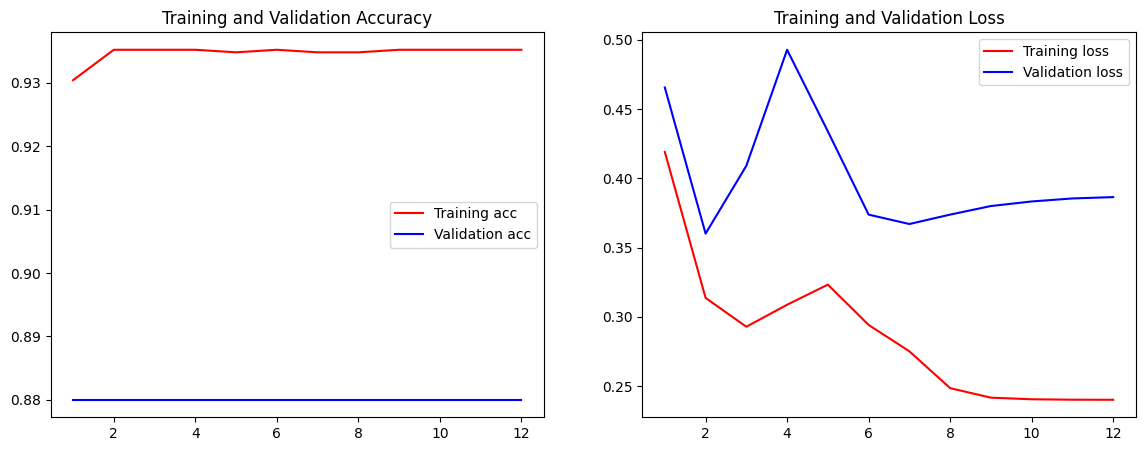

In [8]:
# Plot accuracy and loss curves
def plot_history(history):
    acc = history.history.get('accuracy', [])  # 'accuracy' is not tracked for Siamese; replace with custom metrics if used
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    if acc and val_acc:
        plt.plot(epochs, acc, 'b', label='Training acc', color='red')
        plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss', color='red')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Call the function to plot history
plot_history(history)

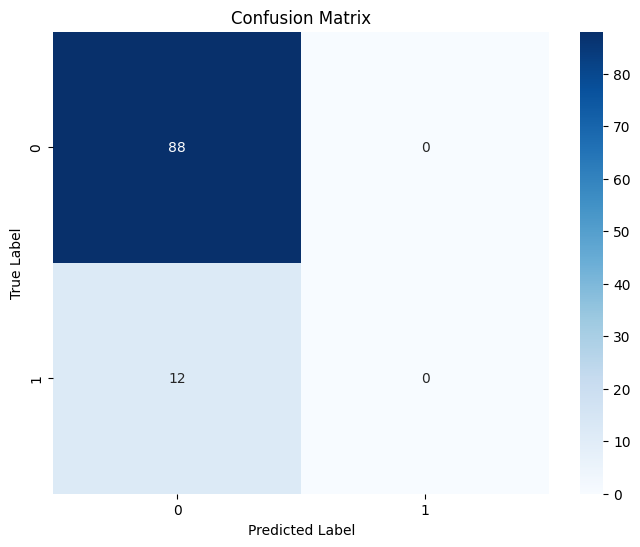

              precision    recall  f1-score   support

  Dissimilar       0.88      1.00      0.94        88
     Similar       0.00      0.00      0.00        12

    accuracy                           0.88       100
   macro avg       0.44      0.50      0.47       100
weighted avg       0.77      0.88      0.82       100



/home/bhavin/miniconda3/envs/Tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bhavin/miniconda3/envs/Tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bhavin/miniconda3/envs/Tensorflow/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [9]:
# Function to generate confusion matrix and classification report
def evaluate_siamese_model(model, X_test_pairs, y_test_pairs, threshold=0.5):
    # Predict similarity scores for the test pairs
    y_pred_probs = model.predict([X_test_pairs[:, 0, :, :], X_test_pairs[:, 1, :, :]], verbose=0)
    
    # Convert similarity scores to binary predictions (0 or 1) based on the threshold
    y_pred = (y_pred_probs >= threshold).astype(int)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_pairs, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print(classification_report(y_test_pairs, y_pred, target_names=["Dissimilar", "Similar"]))

# Call the function to evaluate the model
evaluate_siamese_model(siamese_model, X_test_pairs, y_test_pairs)